# ROS ALE Figure 6

Generates Figure 6 from the manuscript "Lab evolution, transcriptomics, and modeling reveal mechanisms of paraquat tolerance" by Kevin Rychel et al., 2022.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-Up" data-toc-modified-id="Set-Up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set Up</a></span></li><li><span><a href="#Write-Special-Functions" data-toc-modified-id="Write-Special-Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Write Special Functions</a></span></li><li><span><a href="#Generate-Figure" data-toc-modified-id="Generate-Figure-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generate Figure</a></span></li></ul></div>

## Set Up

In [1]:
# use py file to set up workspace
from src.ros_ale_functions import *

# load data
ros_meta = pd.read_csv('input/ros_ale_p1k_metadata.csv', index_col = 0)
hplc_rates = pd.read_csv('input/hplc_files/hplc_rates_kr.csv')
lit_rates = pd.read_csv('input/hplc_files/chen_2021_plos_comp_bio_aerotypes.csv',
                        index_col = 0)
strain_fluxes = pd.read_csv('input/me_model/strain_models_fluxes.csv',
                            index_col = 0)
pq_sweep = pd.read_csv('input/me_model/0_0__1_0__PQ_sweep_TCA.csv')

## Write Special Functions

All plots in this figure use their own functions.

In [2]:
lit_rates

,T,sample,growth_rate,GUR,OUR,APR,biomass_yield,Nexpressed,peptide_per_complex,cofactor_per_complex
simID,,,,,,,,,,
T25_S000,25,0,0.574007,5.945514,9.392770,0.401742,0.536170,587,2.966507,4.002392
T25_S001,25,1,0.177788,7.380906,5.994829,11.964246,0.133772,548,2.695444,3.721823
T25_S002,25,2,0.213196,2.994341,7.894971,0.158807,0.395414,573,2.830508,3.857143
T25_S003,25,3,0.287010,3.473529,7.394752,0.208662,0.458882,582,2.848558,3.879808
T25_S004,25,4,0.281136,4.742294,6.986329,4.352681,0.329232,561,2.728155,3.735437
...,...,...,...,...,...,...,...,...,...,...
T46_S096,46,96,0.268196,3.870958,6.923432,2.097786,0.384777,582,2.875000,3.908654
T46_S097,46,97,0.251381,3.865182,5.839358,2.988292,0.361191,586,3.002387,4.040573
T46_S098,46,98,0.275719,4.075945,6.080340,2.964405,0.375675,583,3.036058,4.067308


In [3]:
def aerotype_plot(hplc_rates, ax, lit_rates = None):
    """
    Draws the aerotype plot for fig 6d
    
    Parameters
    ----------
    hplc_rates: table of hplc data and growth rates
    ax: axes to plot to
    lit_rates: table of similar data from Chen 2021's simulations
        if 'None', don't display
        
    Returns
    -------
    ax: axes with plot
    """

    # plot literature data
    if not(lit_rates is None):
        ax.scatter(lit_rates.GUR, lit_rates.biomass_yield, color = 'lightgray',
                   alpha = 0.5, zorder = 2, s = 2)

    # plot the new data
    ev_label = {True:'Evolved', False: 'Start'}
    pq_shape = {0:'o', 125: 'D', 250: 's', 750: '^'}
    ev_color = {True:'tab:green', False:'k'}

    for (pq, name), group in hplc_rates.groupby(['pq', 'evolved']):

        mean_gluc_rate = -group.glucose_rate.mean()
        mean_biomass_gg = group.biomass_gg.mean()
        std_gluc_rate = group.glucose_rate.sem()
        std_biomass_gg = group.biomass_gg.sem()

        ax.errorbar(mean_gluc_rate, mean_biomass_gg, 
                    xerr = std_gluc_rate, yerr = std_biomass_gg,
                   color = ev_color[name], marker = pq_shape[pq],
                   label = '%s, %i µM PQ'%(ev_label[name], pq),
                   markersize = 6, alpha = 0.7, markeredgecolor = 'k',
                   elinewidth = 1, zorder = 3)        

    # add the isoclines & labels
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    x = np.linspace(xlims[0], xlims[1], 100)
    grs = [1.2, 1, 0.8, 0.6, 0.4]
    y_dict = {}
    for g in grs:
        y_dict[g] = g**2/((180.156/1000)*x)

    for gr, y in y_dict.items():
        ax.plot(x, y, '--', c = 'dimgray', alpha = 0.8, zorder = 1)

    ax.set_ylim(ylims)
    ax.set_xlim(xlims)

    ax.tick_params(labelsize = 7)
    ax.set_xlabel('Glucose uptake rate (mmol/gDCW/h)', fontsize = 7)
    ax.set_ylabel('Biomass Yield (gDCW/g glc)', fontsize = 7)

    return ax

In [4]:
def TCA_flux_bar(strain_fluxes, ax, subsystem = 'Citric Acid Cycle'):
    """
    Draws a bar graph of fluxes for reactions in TCA for fig 6E
    Can be used with other subsystems in strain_fluxes too
    
    Parameters
    ----------
    strain_fluxes: output of ME model, in which rows are reactions,
        one column 'subsystem' categorizes the reaction,
        and remaining columns represent models
    ax: axes to plot to
    subsystem: which subsystem to show in the plot
    
    Returns
    -------
    ax: axes with plot
    """

    # get just the fluxes for the subsystem of interest
    rel_rxns = strain_fluxes.loc[strain_fluxes.subsystem == subsystem]\
        .drop('subsystem', axis = 1).abs()

    # remove reactions that are never used by any strain
    rel_rxns = rel_rxns.loc[(rel_rxns > 1e-20).T.any()]

    # organize for plotting
    to_plot = rel_rxns.stack().reset_index().rename(columns = 
                        {'level_0':'reaction', 'level_1':'model', 0:'flux'})
    to_plot['evolved'] = to_plot.model != '0_0'

    palette = {0:'tab:gray', 1:'tab:green'}

    # plot
    sns.barplot(x = 'evolved', y = 'flux', data = to_plot,
                palette = palette, errwidth = 1.5,
                linewidth = 0.5, edgecolor = 'k', ax = ax)
    sns.stripplot(x = 'evolved', y = 'flux', data = to_plot, 
                  color = 'k', jitter = 0.2, s = 1.5, ax = ax)

    # clean up
    ax.set_xticklabels(['Start', 'Evolved'], rotation = 90)
    ax.tick_params(labelsize = 7)
    ax.set_xlabel('')
    ax.set_ylabel('Optimal Flux in TCA', fontsize = 7)

    return ax

In [5]:
def pq_sweep_plot(pq_sweep, axs):
    """
    Draws two plots showing the effect of evolution on the TCA cycle
    for fig 6F-G
    
    Parameters
    ----------
    pq_sweep: table of data from ME modeling
    axs: list of axes [panel_f, panel_g]
    
    Returns
    -------
    axs: axes with plots
    """
    
    # loop through the strains
    for strain, color in zip(['0_0', '1_0'], ['tab:gray', 'tab:green']):
        
        # get the right columns
        tot_col = 'total_tca_' + strain
        dam_col = 'undamaged_tca_' + strain
        nadh_col = 'nadh_' + strain
        
        # panel f
        axs[0].fill_between(pq_sweep.pq_flux, pq_sweep[dam_col]*100,
                            pq_sweep[tot_col]*100, color = color)
        axs[0].plot(pq_sweep.pq_flux, pq_sweep[dam_col]*100, color = 'k',
                    linewidth = 0.75)
        axs[0].plot(pq_sweep.pq_flux, pq_sweep[tot_col]*100, color = 'k',
                    linewidth = 0.75)
        
        # panel g
        axs[1].plot(pq_sweep.pq_flux, pq_sweep[nadh_col], 
                    color = color, label = strain)
    
    # clean up
    axs[0].set_ylim(0, axs[0].get_ylim()[1])
    axs[1].set_ylim(0, axs[1].get_ylim()[1])

    fontsize = 7
    axs[0].set_ylabel('Proteome Percentage', fontsize = fontsize)
    axs[1].set_ylabel('NADH\nProduced', fontsize = fontsize)

    axs[0].tick_params(labelsize = fontsize)
    axs[1].tick_params(labelsize = fontsize)

    axs[1].legend(fontsize = fontsize, ncol = 2)
    axs[1].set_xlabel('PQ Cycle Flux', fontsize = fontsize)
    
    return axs

## Generate Figure

Panels A, B, and D are added in Illustrator. 

[<AxesSubplot:ylabel='Proteome Percentage'>,
 <AxesSubplot:xlabel='PQ Cycle Flux', ylabel='NADH\nProduced'>]

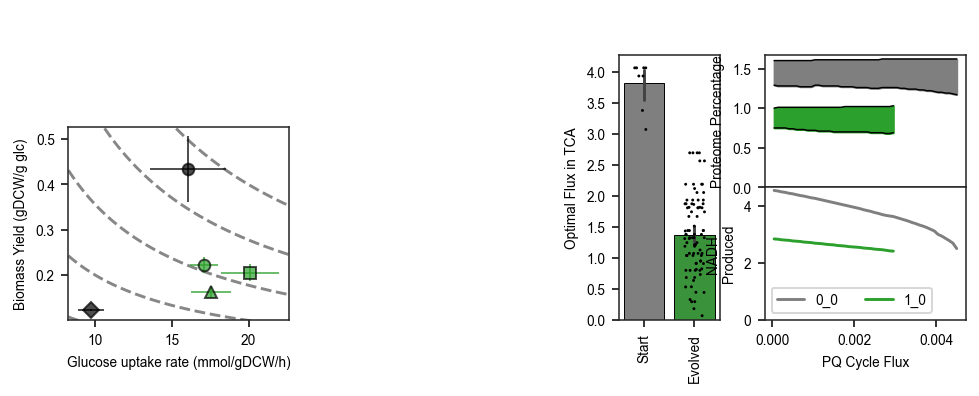

In [6]:
# layout
fig = plt.figure(figsize = (6.85, 2.5), dpi = 140)
subfigs = fig.subfigures(1, 4, width_ratios = [1.1, 1.1, 0.5, 1])
skip, panel_c = subfigs[0].subplots(2, 1, 
                        gridspec_kw = {'height_ratios':[1, 4]})
panel_e = subfigs[2].subplots()
panel_f, panel_g = subfigs[3].subplots(2, 1, sharex = True,
                        gridspec_kw = {'hspace':0})
skip.axis('off')

# Panel C - Aero-types
aerotype_plot(hplc_rates, panel_c)

# Panel E - TCA flux in strain models
TCA_flux_bar(strain_fluxes, ax = panel_e)

# Panel F & G - TCA proteome fraction & NADH production
pq_sweep_plot(pq_sweep, [panel_f, panel_g])

#plt.savefig('output/fig6_raw.pdf')